##### Main focus of this notebook is to implement linear regression using normal equation and gradient descent. And not data exploration, outlier treatment, feature selection.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


# 1. Initial Exploration

In [2]:
columns_from_abalone_names_file = ["Sex", "Length", "Diameter", "Height", "Whole weight", "Shucked weight", 
                                   "Viscera weight", "Shell weight", "Rings"]

In [3]:
data = pd.read_csv("./abalone data/abalone.data.txt", names=columns_from_abalone_names_file)
data.head(5)

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [4]:
data.shape

(4177, 9)

In [5]:
data.describe()

,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


In [6]:
print(data.dtypes)
columns = data.columns
print(len(columns))

Sex                object
Length            float64
Diameter          float64
Height            float64
Whole weight      float64
Shucked weight    float64
Viscera weight    float64
Shell weight      float64
Rings               int64
dtype: object
9


In [7]:
columns

Index(['Sex', 'Length', 'Diameter', 'Height', 'Whole weight', 'Shucked weight',
       'Viscera weight', 'Shell weight', 'Rings'],
      dtype='object')

###### scatter plot shows that our target variable "Rings" is monotonically dependant on other featue varibales in dataset.

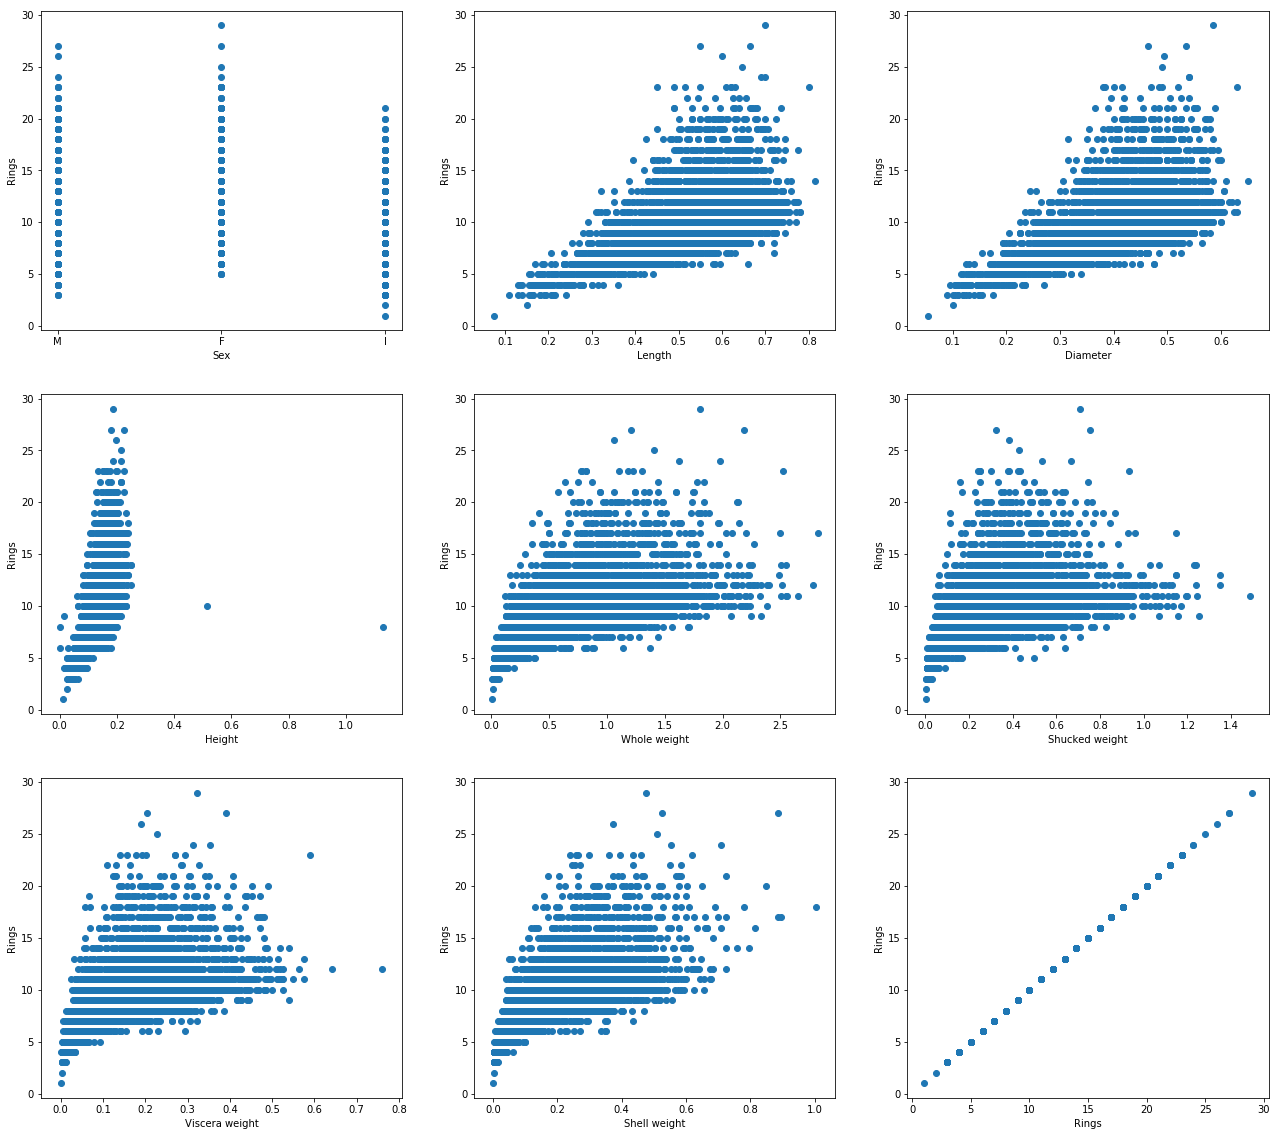

In [8]:
plt.rcParams["figure.figsize"] = (22,20)
for i in range(1, len(columns)+1):
    plt.subplot(3,3,i)
    plt.scatter(x=data[columns[i-1]], y=data["Rings"])
    plt.xlabel(s=columns[i-1])
    plt.ylabel(s="Rings")
plt.show()

##### heatmap shows that features are highly correlated with each other but target - "Rings" isn't.

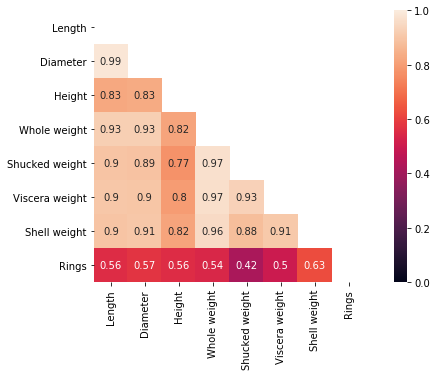

In [9]:
plt.rcParams["figure.figsize"] = [10,5]
mask = np.zeros_like(data.corr())
mask[np.triu_indices_from(mask)] = True
sns.heatmap(data.corr(), square=True, vmin=0, vmax=1,  annot=True , mask=mask)

# 2. train, test dataset creation

In [10]:
from sklearn.model_selection import train_test_split

##### I'm deliberately ignoring multicollinearity between features and selecting some of them.

In [11]:
chossen_data = data[["Length", "Diameter", "Shell weight", "Rings"]]

In [12]:
def split_data(chossen_data):
    X_train, X_test, y_train, y_test = train_test_split(chossen_data.drop("Rings", axis=1),
                                                    chossen_data["Rings"], 
                                                    test_size=0.33, random_state=40)
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    y_train = y_train.reset_index(drop=True)
    y_test = y_test.reset_index(drop=True)
    return  X_train, X_test, y_train, y_test

In [13]:
X_train, X_test, y_train, y_test = split_data(chossen_data)

In [14]:
X_train.head()

,Length,Diameter,Shell weight
0,0.565,0.450,0.2490
1,0.315,0.235,0.0405
2,0.330,0.260,0.0650
3,0.420,0.330,0.1000
4,0.420,0.315,0.1015


# 4. scaling

##### We can speed up gradient descent by having each of our input values in roughly the same range. This is because θ will descend quickly on small ranges and slowly on large ranges, and so will oscillate inefficiently down to the optimum when the variables are very uneven. (Credits:- Andrew ng)

In [15]:
from sklearn.preprocessing import MinMaxScaler

In [16]:
def scaling(X_train, X_test, y_train, y_test, scale):
    
    if scale:
        training_X_scaler = MinMaxScaler()
        training_X_scaler = training_X_scaler.fit(X_train)
        X_train  = pd.DataFrame(training_X_scaler.transform(X_train), columns=["Length", "Diameter", "Shell weight"])
        X_test = pd.DataFrame(training_X_scaler.transform(X_test), columns=["Length", "Diameter", "Shell weight"])
        
        training_y_scaler = MinMaxScaler()
        training_y_scaler = training_y_scaler.fit(np.array(y_train).reshape(-1,1))
        y_train  = pd.DataFrame(training_y_scaler.transform(np.array(y_train).reshape(-1,1)), columns=["Rings"])
        y_test  = pd.DataFrame(training_y_scaler.transform(np.array(y_test).reshape(-1,1)), columns=["Rings"])
        
    return X_train, X_test, y_train, y_test

# 5. linear regression using normal equation

<img src="static/lr using linear algebra.png">

In [17]:
FIT_INTERCEPT = True

In [18]:
X_train, X_test, y_train, y_test = scaling(X_train, X_test, y_train, y_test, scale=True)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


##### we need to add extra features of all ones if want to include intercept term to our linear hypothesis. 

In [19]:
def adjust_for_intercept(X_train, X_test, fit_intercept):
    
    if fit_intercept:
        # adidng 1 column of 1's to X_train & X_test for bias term
        X_train["bias"] = [1] * len(X_train)
        X_train = X_train[["bias", "Length", "Diameter", "Shell weight"]]

        X_test["bias"] = [1] * len(X_test)
        X_test = X_test[["bias", "Length", "Diameter", "Shell weight"]]

    return X_train, X_test

In [20]:
X_train, X_test = adjust_for_intercept(X_train, X_test, fit_intercept=FIT_INTERCEPT)

In [21]:
X_train.head()

,bias,Length,Diameter,Shell weight
0,1,0.662162,0.663866,0.246637
1,1,0.324324,0.302521,0.038864
2,1,0.344595,0.344538,0.063279
3,1,0.466216,0.462185,0.098156
4,1,0.466216,0.436975,0.099651


In [22]:
%%time
weigths = np.linalg.pinv(X_train.T.dot(X_train).values).dot(X_train.T).dot(y_train)

CPU times: user 3.71 ms, sys: 2.01 ms, total: 5.72 ms
Wall time: 4.32 ms


In [23]:
print("weights:-", weigths)
print("intercept:-", weigths.shape)

weights:- [[ 0.19546634]
 [-0.34518018]
 [ 0.37484407]
 [ 0.45869374]]
intercept:- (4, 1)


##### hypothesis on scaled data = 0.195 - 0.345* Length + 0.375* Diameter + 0.459* Shell weight
##### hypothesis on unscaled data = 6.463 - 13.06* Length + 17.639* Diameter + 12.799* Shell weight

In [24]:
preds = X_test.dot(weigths)

In [25]:
preds.rename({0:"predictions"}, axis=1).join(y_test).head()
#pd.DataFrame(preds.astype("int")).join(y_test).head()

,predictions,Rings
0,0.446611,0.464286
1,0.299959,0.285714
2,0.254257,0.178571
3,0.284396,0.214286
4,0.307883,0.321429


In [26]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [27]:
mse = mean_squared_error(y_pred=preds, y_true=y_test)
#mse = mean_squared_error(y_pred=pd.DataFrame(preds.astype("int")), y_true=y_test)
rmse = sqrt(mse)
print("rmse:-", rmse)

rmse:- 0.08909823731983786


##### plotting density of predicted and original target variable to check the statistics of both distributions.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


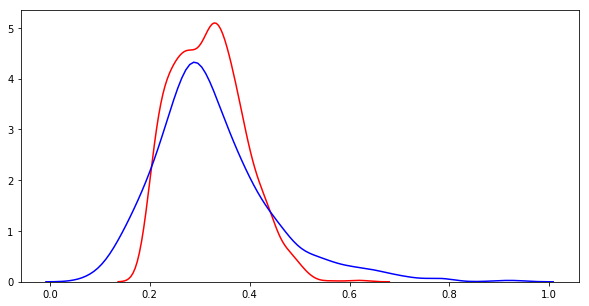

In [28]:
sns.kdeplot(data=preds[0].values, color="r")
sns.kdeplot(data=y_test["Rings"].values, color="b")

# 6. cross-check :- linear regression using sklearn

In [29]:
X_train, X_test, y_train, y_test = split_data(chossen_data)
X_train, X_test, y_train, y_test = scaling(X_train, X_test, y_train, y_test, scale=True)

from sklearn.linear_model import LinearRegression
lr = LinearRegression(fit_intercept=True)
lr_model = lr.fit(X_train, y_train)
print("weights:- ", lr_model.coef_)
print("intercept:-", lr_model.intercept_)

weights:-  [[-0.34518018  0.37484407  0.45869374]]
intercept:- [0.19546634]


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


# 7. linear regression using gradient descent

#### implementation of both stochastic and mini-batch gradient descent

<img src="static/gradient descent.png">

In [30]:
FIT_INTERCEPT = True

In [31]:
X_train, X_test, y_train, y_test = split_data(chossen_data)
X_train, X_test, y_train, y_test = scaling(X_train, X_test, y_train, y_test, scale=True)
X_train, X_test = adjust_for_intercept(X_train, X_test, fit_intercept=FIT_INTERCEPT)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype int64 was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [32]:
X_train = np.array(X_train) 
y_train = np.array(y_train).reshape(-1,1)
X_test = np.array(X_test) 
y_test = np.array(y_test).reshape(-1,1)

In [33]:
#initial bias & weights
def initialize_weights(no_of_variables):
    weights = np.zeros((no_of_variables, 1))
    return weights

In [34]:
weights = initialize_weights(X_train.shape[1])
weights

array([[0.],
       [0.],
       [0.],
       [0.]])

In [35]:
def prediction(X, weights):
    yhat = X.dot(weights)
    return yhat

In [36]:
print(prediction(X_train[:2], weights))
print(prediction(X_train[:2], weights).shape)

[[0.]
 [0.]]
(2, 1)


In [37]:
def cost(y, pred):
    return np.square(y - pred).mean()/2

In [38]:
cost(y_test[:5], prediction(X_test[:5], weights) )

0.04783163265306122

In [39]:
def calculate_gradients(X, y, weights, learning_rate):
    yhat = prediction(X, weights)
    m = len(y)
    gradients =  (1/m) * learning_rate * (X.T.dot(yhat-y))
    new_weights = weights - gradients
    return new_weights

In [40]:
def batch_gradient_descent(X_train, X_test, y_train, y_test, batch_size, learning_rate, fit_intercept, iterations):
    
    weights = initialize_weights(X_train.shape[1])
    weights_history = []
    cost_history = []
    
    for i in range(iterations):
        for j in range(0, len(y_train), batch_size):
            X = X_train[j : j + batch_size]
            y = y_train[j: j + batch_size]
            weights = calculate_gradients(X, y, weights, learning_rate)
        weights_history.append(weights)
        cost_history.append(cost(y_test, prediction(X=X_test, weights=weights)))
        
    return weights, weights_history, cost_history

In [41]:
BATCH_SIZE = 10  #for mini-batch gradient descent
LEARNING_RATE = 0.00001
ITERATIONS = 1000

In [42]:
%%time
weights, weights_history, cost_history = batch_gradient_descent(X_train, X_test, y_train, y_test, 
                                                                batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE,
                                                                fit_intercept=FIT_INTERCEPT, iterations=ITERATIONS)

CPU times: user 1.94 s, sys: 14.6 ms, total: 1.95 s
Wall time: 1.98 s


In [43]:
weights

array([[0.16794809],
       [0.11439706],
       [0.1133799 ],
       [0.05401965]])

##### plotting cost history of gradient descent shows that it is converging

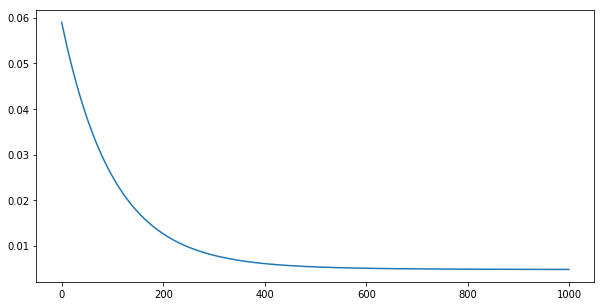

In [44]:
plt.plot(cost_history)

In [45]:
preds = X_test.dot(weigths)
mse = mean_squared_error(y_pred=preds, y_true=y_test)
#mse = mean_squared_error(y_pred=pd.DataFrame(preds.astype("int")), y_true=y_test)
rmse = sqrt(mse)
print("rmse:-", rmse)

rmse:- 0.08909823731983786


##### plotting density of predicted and original target variable to check the statistics of both distributions.

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


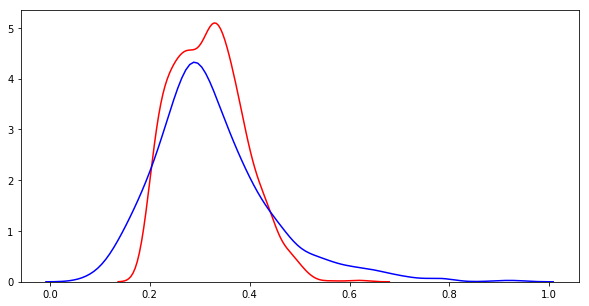

In [46]:
sns.kdeplot(data=preds.reshape(-1), color="r")
sns.kdeplot(data=y_test.reshape(-1), color="b")

# Comparison:-

### 1. Implementation :-
##### Implementing linear regression using normal equation i.e. using linear algebra is quite easy and takes less time. 
##### while implementing gradient descent approach takes much more time.

### 2. Hypothesis weights:-
##### Linear algebra guarantees best hypothesis weights. In other words, cost function will be at lowest when used these weights.
##### Gradient descent algorithm provides optimal weights. (hyperparameters tuning helps)

### 3. Execution time:-
##### As seen above, lnormal equation implementation takes less time to calculate weights.
##### GD approach is much slower. Mainly because of no of iterations. (scaling the dataset and hyperparameters tuning helps)

### 4. Use:-
##### Normal equation approach can be used when dataset is smaller in size because this uses all data at once to calculate weights.
##### GD algorithm is used when dataset is too large to fit in the memory because thsi algorithm uses mini batches of data to calculate weights.